# 世界幸福报告——聚类分析
![幸福图片](dataset/happiness.jpg)

## 课题目标

本次实验旨在利用给定的数据集进行国家幸福感聚类分析。数据集涵盖了多个影响国家幸福感的指标，包括但不限于：

1. gdp_per_capita - 人均国内生产总值
2. family - 家庭满意度
3. health - 平均健康状况
4. reedom - 自由感受程度
5. generosity - 公众对本国慷慨程度的看法
6. government_trust - 公众对政府的信任程度
7. dystopia_residual - 与世界上最悲观国家的比较得分
8. continent - 国家所在的洲
9. cpi_score - 腐败感知指数，用于排名国家的“公共部门腐败感知水平”
10. Year - 数据属性的年份度量
11. Country - 国家名称
12. social_support - 衡量一个人感受到的社会支持和关爱


通过这次实验，旨在：
- 确定哪些指标对于划分聚类群组具有重要影响，并发现潜在的群组模式或共性特征。
- 使用适当的数据预处理方法，构建并比较不同聚类算法（如K均值、层次聚类等）的效果，选择合适的聚类数目和模型评估指标。
- 最终呈现聚类结果，提供对不同聚类群组的解释和分析，探讨各群组之间的差异性和相似性，并对聚类结果进行合理解释。

## 课题数据集
本次聚类分析所使用的数据集为来自Kaggle竞赛的"Happiness and Corruption 2015-2020"(https://www.kaggle.com/datasets/eliasturk/world-happiness-based-on-cpi-20152020/data), 该数据集对2015-2020《世界幸福报告》（幸福分数是由盖洛普世界民意调查（GWP）中的受访者对主要生活评估问题的平均回答得出的。Cantril Ladder（Cantril阶梯）是其中的核心部分，受访者被要求想象他们能够过上的最好生活，并根据这一标准对他们现有生活的幸福感进行评分）中所有国家的有效数据进行了预处理和汇总，并添加了从transparency(https://www.transparency.org/) 中获得的腐败感知指数，合并了基于国家和年份的数据集，将数据转换为长数据格式，并使用0填充填充了缺失得到数据。数据集共包括132个国家2015-2020年的共792条数据，数据集的目标为利用特征对国家进行聚类，发现潜在的相似性模式和群组，探索在这些年份中国家之间的共性和差异性，并理解不同群组之间的特征差异，为理解影响幸福感的主要因素提供更深入的洞察。

## 数据准备

In [85]:
import pandas as pd 
import numpy as np  #For mathematical calculatons
import seaborn as sns #For data visualization
import matplotlib.pyplot as plt # For plotting graphs
import plotly.graph_objs as go
import warnings      #To ignore warnings
import time
warnings.filterwarnings ("ignore")


from sklearn import cluster,mixture


# import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()

从指定路径加载数据，并对数据进行一定的预处理：按照年份将数据集分割，并移除了指定的列，返回了一个字典，其中包含了每个年份对应的数据集。

In [86]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

class DataPreprocessing:
    def __init__(self, data_path):
        self.data_path = data_path

    def load_data(self):
        df = pd.read_csv(self.data_path)
        return df

    def preprocess_data(self, df):
        column_names = ["gdp_per_capita", "health", "cpi_score", "freedom", "government_trust", "social_support",
                        "dystopia_residual", "Country", "Year", "continent", "generosity", "family",
                        "happiness_score"]

        df = df.reindex(columns=column_names)

        # Filter data by year
        year_range = list(range(2015, 2021))
        data_by_year = {}
        for year in year_range:
            year_data = df[df['Year'] == year]
            year_data = year_data.drop(["happiness_score", "Country", "continent", "Year"], axis=1)

            # Min-Max scaling
            scale = MinMaxScaler()
            year_data_scaled = scale.fit_transform(year_data)
            year_data_scaled = pd.DataFrame(year_data_scaled, columns=year_data.columns)

            data_by_year[year] = year_data_scaled

        return data_by_year

In [87]:
data_path = "dataset/WorldHappiness_Corruption_2015_2020.csv"
data_processor = DataPreprocessing(data_path)
df = data_processor.load_data()
data_by_year = data_processor.preprocess_data(df)

print(data_by_year[2015].describe())
print(data_by_year[2016].describe())
print(data_by_year[2017].describe())
print(data_by_year[2018].describe())
print(data_by_year[2019].describe())
print(data_by_year[2020].describe())

       gdp_per_capita      health   cpi_score     freedom  government_trust  \
count      132.000000  132.000000  132.000000  132.000000        132.000000   
mean         0.554095    0.601912    0.419034    0.614154          0.263904   
std          0.242992    0.229364    0.254682    0.228766          0.221124   
min          0.000000    0.000000    0.000000    0.000000          0.000000   
25%          0.385835    0.455729    0.234375    0.447903          0.118125   
50%          0.599064    0.649011    0.337500    0.650620          0.189462   
75%          0.741133    0.765232    0.568750    0.784728          0.329913   
max          1.000000    1.000000    1.000000    1.000000          1.000000   

       social_support  dystopia_residual  generosity      family  
count           132.0         132.000000  132.000000  132.000000  
mean              0.0           0.587207    0.294481    0.663763  
std               0.0           0.194527    0.165463    0.228505  
min               0.

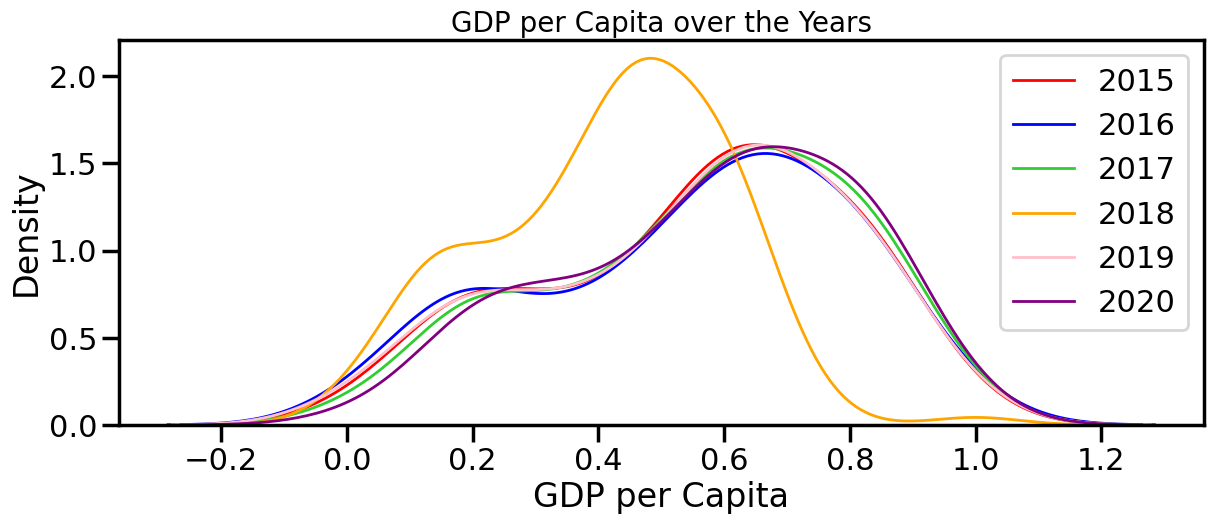

In [88]:
plt.figure(figsize=(14,5))

# 绘制每年的 GDP per Capita 数据
sns.kdeplot(data_by_year[2015]['gdp_per_capita'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['gdp_per_capita'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['gdp_per_capita'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['gdp_per_capita'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['gdp_per_capita'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['gdp_per_capita'], color='purple', linewidth=2, label='2020')

plt.title('GDP per Capita over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('GDP per Capita')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


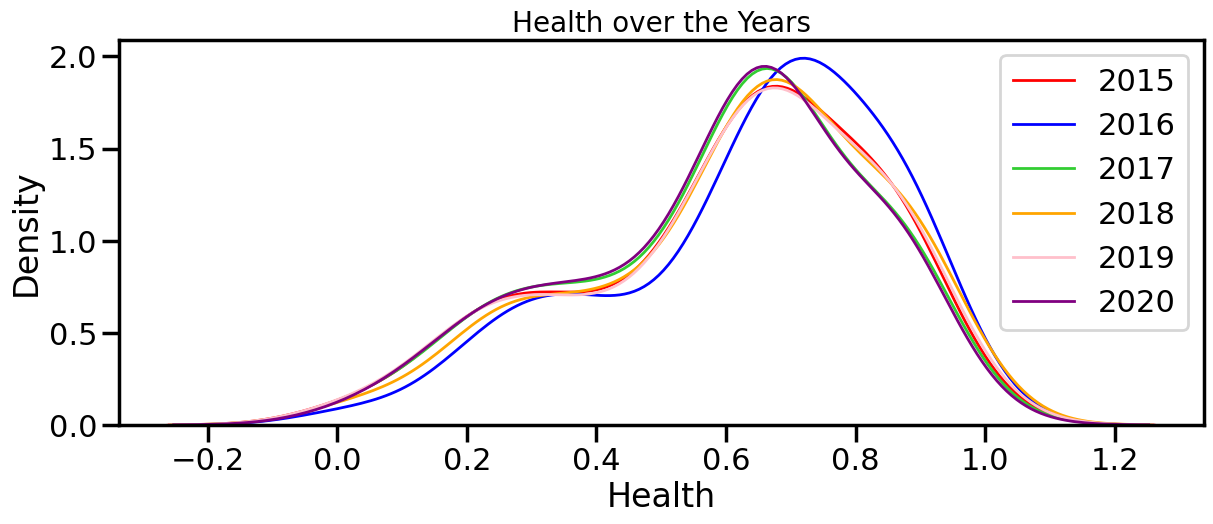

In [89]:
plt.figure(figsize=(14,5))

# 绘制每年的健康数据
sns.kdeplot(data_by_year[2015]['health'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['health'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['health'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['health'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['health'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['health'], color='purple', linewidth=2, label='2020')

plt.title('Health over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Health')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


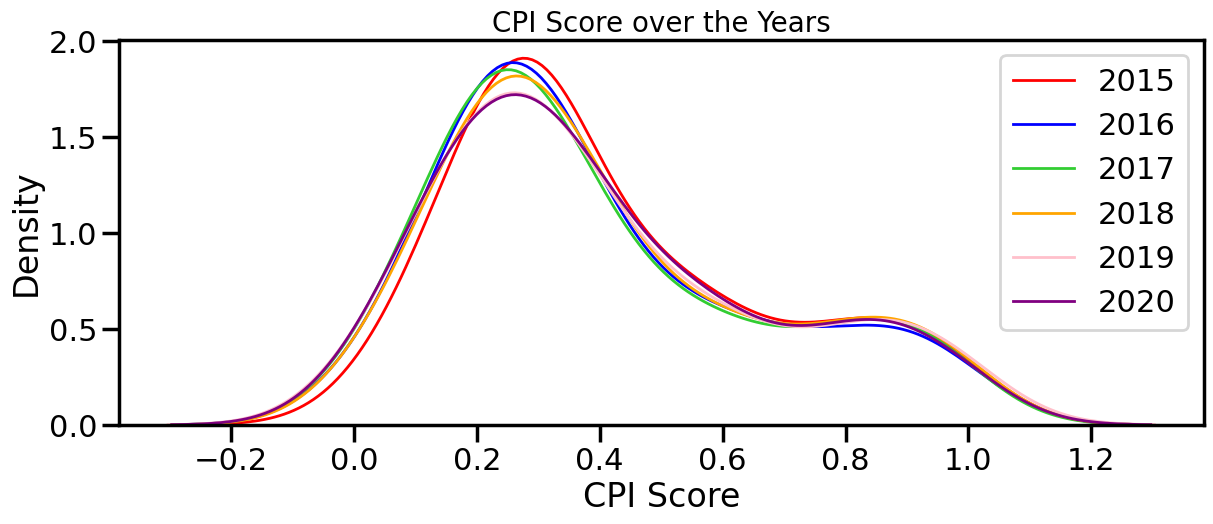

In [90]:
plt.figure(figsize=(14,5))

# 绘制每年的 CPI Score 数据
sns.kdeplot(data_by_year[2015]['cpi_score'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['cpi_score'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['cpi_score'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['cpi_score'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['cpi_score'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['cpi_score'], color='purple', linewidth=2, label='2020')

plt.title('CPI Score over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('CPI Score')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()

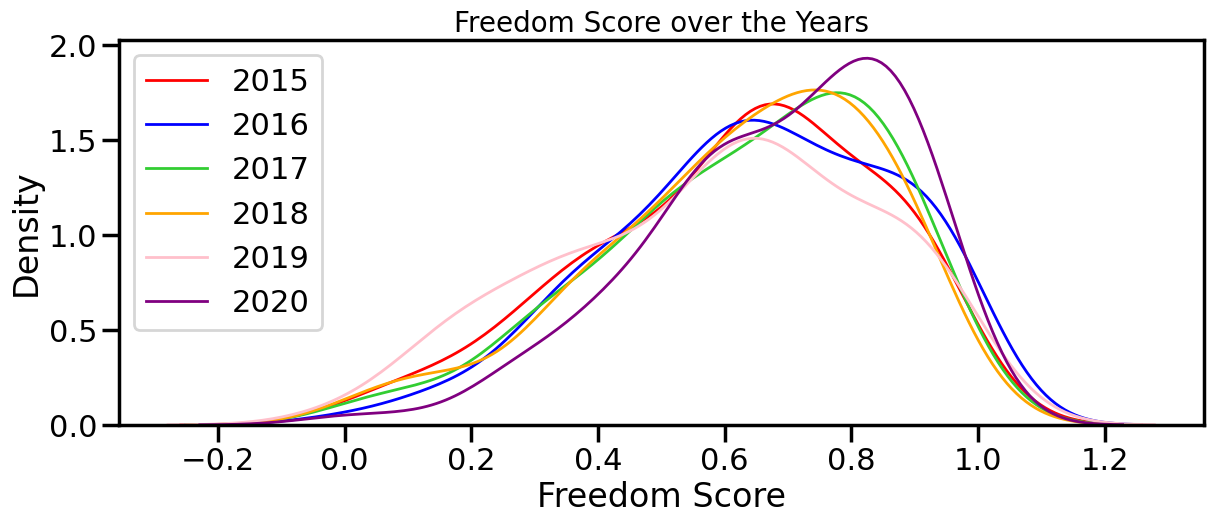

In [91]:
plt.figure(figsize=(14,5))

# 绘制每年的 Freedom 数据
sns.kdeplot(data_by_year[2015]['freedom'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['freedom'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['freedom'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['freedom'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['freedom'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['freedom'], color='purple', linewidth=2, label='2020')

plt.title('Freedom Score over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Freedom Score')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


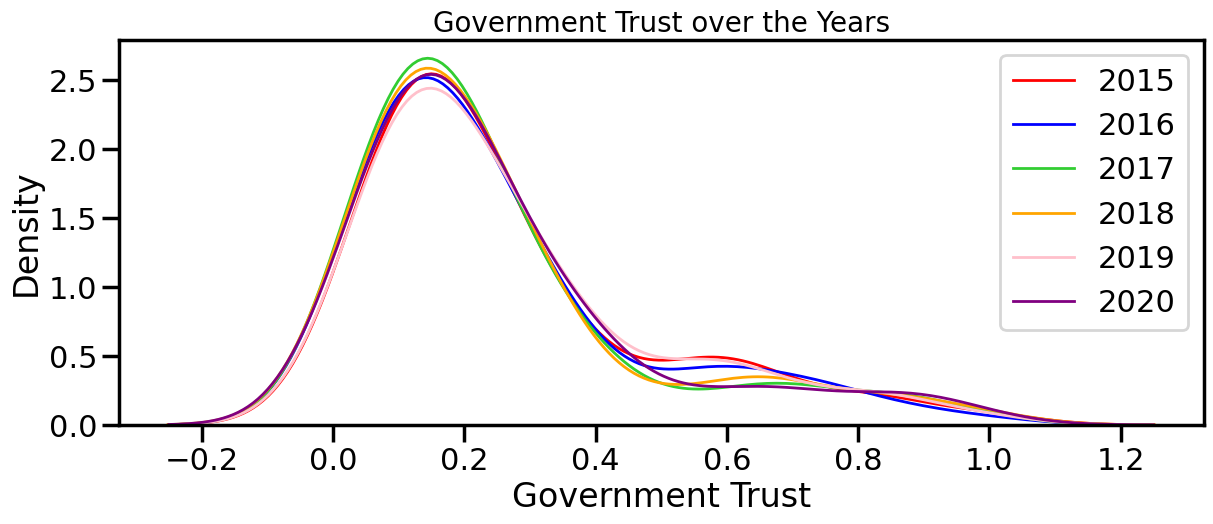

In [92]:
plt.figure(figsize=(14,5))

# 绘制每年的 Government Trust 数据
sns.kdeplot(data_by_year[2015]['government_trust'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['government_trust'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['government_trust'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['government_trust'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['government_trust'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['government_trust'], color='purple', linewidth=2, label='2020')

plt.title('Government Trust over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Government Trust')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


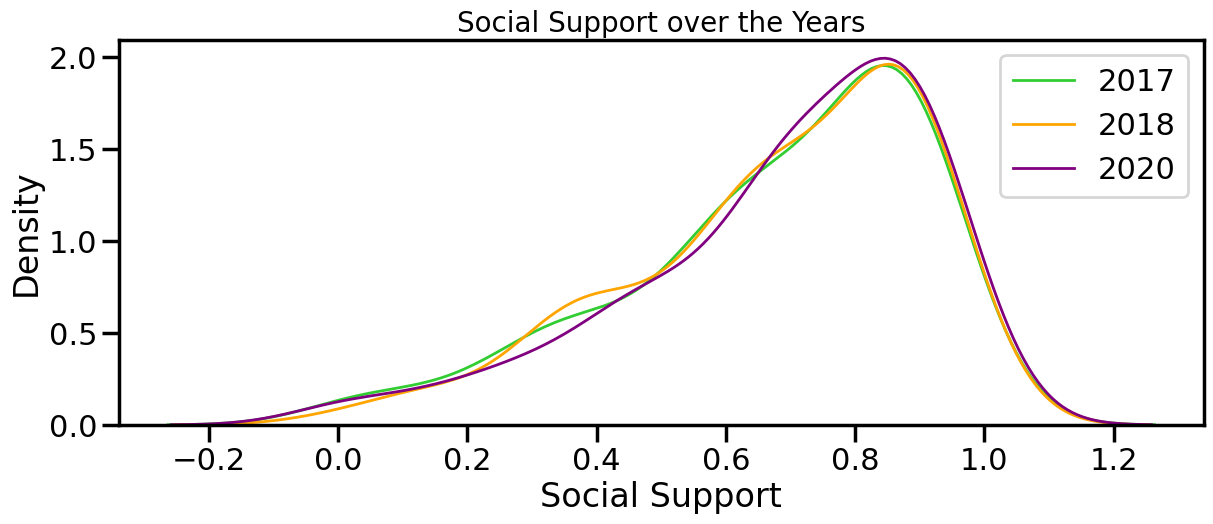

In [93]:
plt.figure(figsize=(14,5))

# 绘制每年的 Social Support 数据
#其中2015,2016,2019年的Social Support 数据全为0
sns.kdeplot(data_by_year[2015]['social_support'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['social_support'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['social_support'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['social_support'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['social_support'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['social_support'], color='purple', linewidth=2, label='2020')

plt.title('Social Support over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Social Support')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


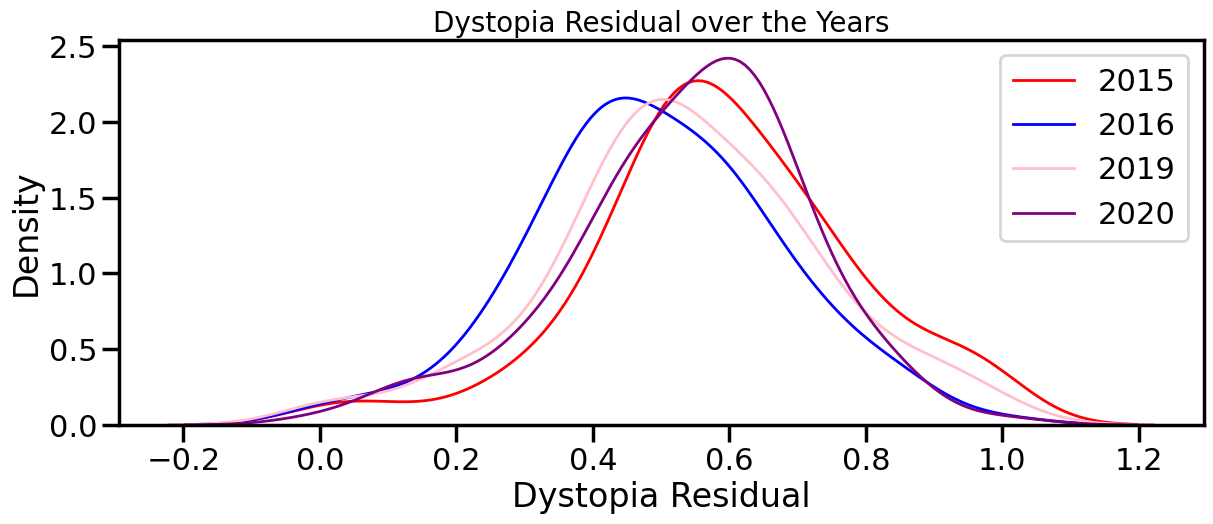

In [94]:
plt.figure(figsize=(14,5))

# 绘制每年的 Dystopia Residual 数据
sns.kdeplot(data_by_year[2015]['dystopia_residual'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['dystopia_residual'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['dystopia_residual'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['dystopia_residual'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['dystopia_residual'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['dystopia_residual'], color='purple', linewidth=2, label='2020')

plt.title('Dystopia Residual over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Dystopia Residual')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


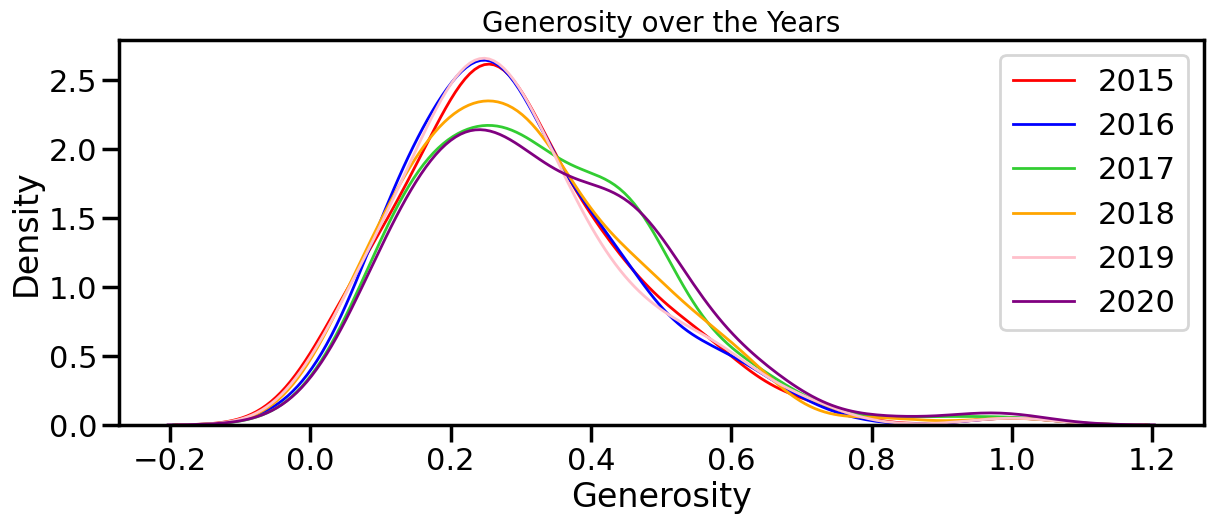

In [95]:
plt.figure(figsize=(14,5))

# 绘制每年的 Generosity 数据
sns.kdeplot(data_by_year[2015]['generosity'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['generosity'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['generosity'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['generosity'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['generosity'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['generosity'], color='purple', linewidth=2, label='2020')

plt.title('Generosity over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Generosity')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()


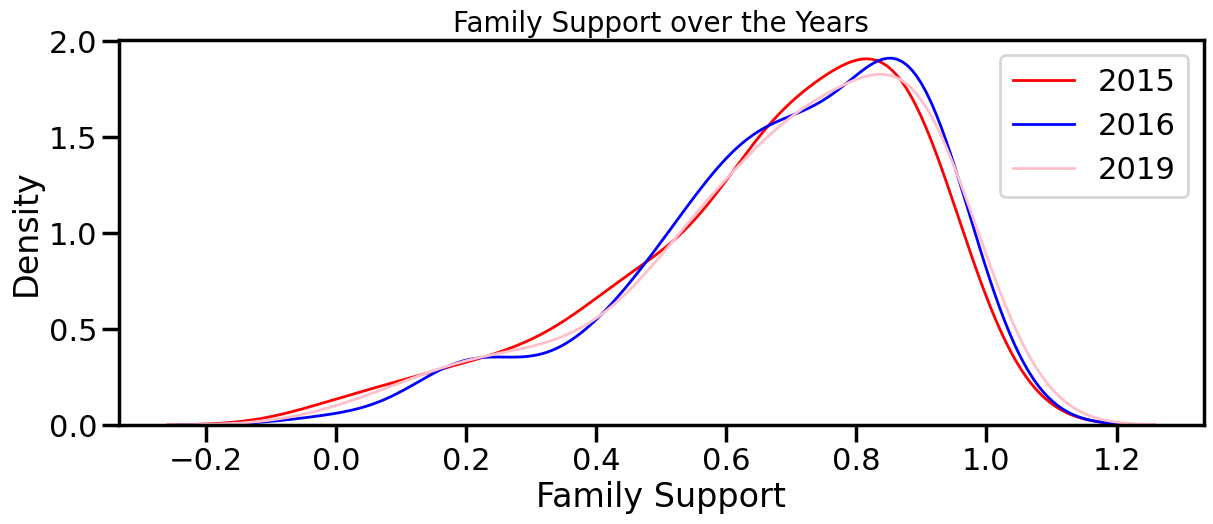

In [96]:
plt.figure(figsize=(14,5))

# 绘制每年的 Family 数据
sns.kdeplot(data_by_year[2015]['family'], color='red', linewidth=2, label='2015')
sns.kdeplot(data_by_year[2016]['family'], color='blue', linewidth=2, label='2016')
sns.kdeplot(data_by_year[2017]['family'], color='limegreen', linewidth=2, label='2017')
sns.kdeplot(data_by_year[2018]['family'], color='orange', linewidth=2, label='2018')
sns.kdeplot(data_by_year[2019]['family'], color='pink', linewidth=2, label='2019')
sns.kdeplot(data_by_year[2020]['family'], color='purple', linewidth=2, label='2020')

plt.title('Family Support over the Years', size=20)
plt.legend()  # 添加图例
plt.xlabel('Family Support')  # x轴标签
plt.ylabel('Density')  # y轴标签
plt.show()

## 聚类分析

1. k-means clustering

k-means是最简单的无监督学习算法之一，可以解决众所周知的聚类问题。该过程遵循一种简单易行的方法，通过一定数量的先验固定的聚类（假设k个聚类）对给定的数据集进行分类。其主要思想是定义k个中心，每个中心对应一个集群。

In [106]:
from sklearn.cluster import KMeans

#K means Clustering 
def doKmeans(data, nclust=2):
    model = KMeans(nclust)
    start_time = time.time()
    model.fit(data)
    clust_labels = model.predict(data)
    end_time = time.time()
    cost_time = end_time-start_time
    cent = model.cluster_centers_
    return (clust_labels, cent, cost_time)


In [107]:
#2015年的
clust_labels, cent, cost_time = doKmeans(data_by_year[2015], 6)
kmeans = pd.DataFrame(clust_labels)
data_by_year[2015].insert((data_by_year[2015].shape[1]),'kmeans',kmeans)

data_by_year[2015].head()

ValueError: cannot insert kmeans, already exists

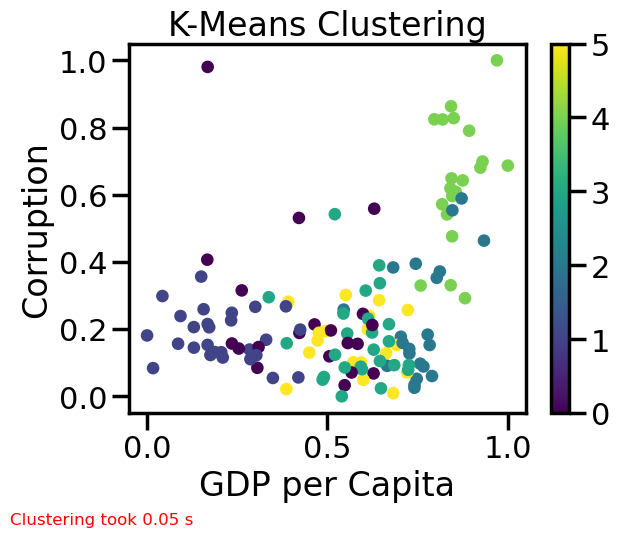

In [114]:
#Plot the clusters obtained using k means
# 绘制散点图
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(data_by_year[2015]['gdp_per_capita'], data_by_year[2015]['government_trust'],
                        c=kmeans[0], s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Corruption')
plt.colorbar(scatter)

# 添加消耗时间的文本
text = f'Clustering took {cost_time:.2f} s'  # 格式化文本
ax.text(-0.3, -0.3, text, transform=ax.transAxes, fontsize=12, color='blue')  # 在图表底部添加文本
plt.show()


2. Hierarchical clustering

3. MeanShift Clustering

4. Spectral Clustering

5. DBScan Clustering

6. Birch Clustering

7. AffinityPropagation Clustering

8. GaussianMixture Clustering

9. Agglomerative Clustering

In [ ]:
#在这种情况下，幸福感得分取决于多种属性或实践——GDP、家庭、健康、腐败等。我们的目标是根据这些数据进行聚类，将相似的国家划分在一起。